In [1]:
%matplotlib inline


Benchmark performance of different USPORF in 3D toy dataset

This example shows characteristics and compares the performance of USPORF
with different distance matrices on 3D datasets.

Algorithms:
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Unsupervised Sparse Projection Oblique Randomer Forest(USPORF), 
`UnsupervisedRandomForest`
    - We will test if USPORF can outperform Robust covariance

USPORF matrics:
- Similarity matrix
- The depth of the nearest common ancestor of the leaf nodes
- The length of the shortest path of the leaf nodes

Benchmarks
- accuracy_score
- roc_auc_score?


d_noise =  0


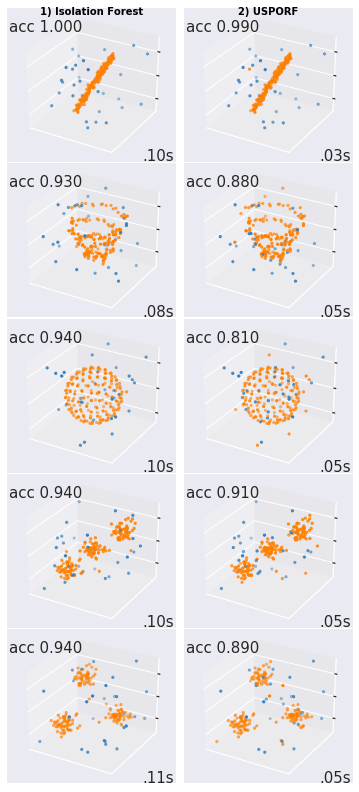

In [32]:
"""
============================================================================
Benchmark performance of different USPORF in 3D toy dataset
============================================================================

This example shows characteristics and compares the performance of USPORF
with different distance matrices on 3D datasets.

Algorithms:
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Unsupervised Sparse Projection Oblique Randomer Forest(USPORF), 
`UnsupervisedRandomForest`
    - We will test if USPORF can outperform Robust covariance

USPORF matrics:
- Similarity matrix
- The depth of the nearest common ancestor of the leaf nodes
- The length of the shortest path of the leaf nodes

Benchmarks
- accuracy_score
- roc_auc_score?

"""


#-------------------------------------------------------------------
# Graphing and calculation packages
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
from sklearn.datasets import make_moons, make_blobs

# Algorithm packages
from sklearn import svm
from sklearn.ensemble import IsolationForest
from rerf.urerf import UnsupervisedRandomForest

# Performance measurement packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import tree
from sklearn import datasets
import matplotlib.cm as cm
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.cluster import AgglomerativeClustering

print(__doc__)

#-------------------------------------------------------------------
# Data parameter
d_noise = 0  # number of Gaussian dimensional noise
n_samples = 200
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
line_sd = 0.06  # sd of the line in dataset 1 and 2
cluster_sd = 0.2  # sd of the cluster in dataset 4 and 5
noise_sd = 2  # sd of the cluster in dimensional noise

# Define datasets
## 1: Linear
def fun_linear(samples=1, sd=0.0):
    t_lin = np.transpose(np.linspace(-1, 1, samples))
    X_lin = np.c_[
        0.4 * t_lin + sd * np.random.randn(samples),
        0.6 * t_lin + sd * np.random.randn(samples),
        t_lin + sd * np.random.randn(samples),
    ]
    return X_lin


X_lin = fun_linear(samples=n_inliers, sd=line_sd)

## 2: Helix
def fun_helix(samples=1, sd=0.0):
    t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, samples))
    xline = t_hex * np.cos(t_hex)  # before rescale
    xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(samples)
    yline = t_hex * np.sin(t_hex)  # before rescale
    yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(samples)
    zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
        max(t_hex) - min(t_hex)
    ) * 2 + sd * np.random.randn(samples)
    X_hex = np.c_[xline, yline, zline]
    return X_hex


X_hex = fun_helix(samples=n_inliers, sd=line_sd)

## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))

## 4: Gaussian Mixture
def gaussian_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_gau = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_gau


X_gau = gaussian_blobs(samples=n_inliers, sd=cluster_sd)

## 5: Misaligned Gaussian Mixture
def misaligned_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_misaligned = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_misaligned


X_misaligned = misaligned_blobs(samples=n_inliers, sd=cluster_sd)

## 6: Whole dataset
# datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]
datasets3D = [ X_hex]

# define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
# label 1 as inliers, -1 as outliers

#-------------------------------------------------------------------
# Define algorithm to be compared
anomaly_algorithms = [
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         behaviour = "new", random_state=42)),
    (
        "USPORF",
        UnsupervisedRandomForest(
            feature_combinations="auto",
            max_depth=None,
            max_features="auto",
            min_samples_split="auto",
            n_estimators=50,
            n_jobs=None,
            projection_matrix="RerF",
        ),
    ),
]
#    ("NCA", RandomTreesEmbedding(n_estimators=50, random_state=0, max_depth=5))

#-------------------------------------------------------------------
# related functions

# the depth of the nearest common ancestor of the leaf nodes 
# sample i and j land into (take the reciprocal to make it a distance);
def NCA(forest, samples):
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)

    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
    
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                d[i, j] = d[i, j]+(path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
            

    d = d / n_estimator
    d_Nearest_Common_Ancestor = [1/x for x in d]
    d_Nearest_Common_Ancestor = np.asarray(d_Nearest_Common_Ancestor)
    
    return d_Nearest_Common_Ancestor

# the length of the shortest path of the leaf nodes sample i and j land into
def SP(forest, samples): 
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)
    
    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
        
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                splitting_depth = (path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
                depth_i = (path[[i, i]].sum(axis=0) == len(sample_ids)).sum()
                depth_j = (path[[j, j]].sum(axis=0) == len(sample_ids)).sum()
                d[i, j] = d[i, j]+depth_i+depth_j-2*splitting_depth

    d_shortest_path = d / n_estimator
    d_shortest_path = np.asarray(d_shortest_path)
    return d_shortest_path


# the probability of sample i and j landing into the same lead node
# (take 1 minus the value to make it a distance).
def PM(clf, samples): 
    
    n_sample = samples.shape[0]
    Y = clf.transform(samples)
    prob = np.zeros([n_sample, n_sample])
    
    for i in range(n_sample):
        for j in range(n_sample):
            leaf_i = Y[i, :]
            leaf_j = Y[j, :]
            p = leaf_i.dot(leaf_j.transpose()).todense()
            prob[i, j] = p[0, 0]

    prob = 1 - prob / Y.shape[1]
    prob = np.asarray(prob)
    return prob

# `fit_predict` function for USPORF
def FitPredict(algorithm, data): 
    sim_mat = algorithm.transform() # create similarity matrix
    sim_sum = sim_mat.sum(axis=1) # score from row sum value
    sU = np.argsort(sim_sum)
    indicesU = sU[
        : int(np.floor(outliers_fraction * data.shape[0]))
    ]  # outlier indeces
    y_pred = np.ones(data.shape[0])
    y_pred[indicesU] = -1
    y_pred = y_pred.astype(int)  # convert float to int array    
    return(y_pred)

# predict outlier from the distance matrics
def OutPredict(mat, data):
    sim_sum = mat.sum(axis=1) # score from row sum value
    sU = np.argsort(sim_sum)
    indicesU = sU[
        : int(np.floor(outliers_fraction * data.shape[0]))
    ]  # outlier indeces
    y_pred = np.ones(data.shape[0])
    y_pred[indicesU] = -1
    y_pred = y_pred.astype(int)  # convert float to int array    
    return(y_pred)

    
    

#-------------------------------------------------------------------
# Plot
plt.figure(figsize=((len(anomaly_algorithms)) * 2 + 1, len(datasets3D) * 2 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    # add uniform distribution outliers
    X = np.concatenate(
        [X, rng.uniform(low=-1.5, high=1.5, size=(n_outliers, 3))], axis=0
    )
    # add Gaussian dimensional noise, set the center at origin
    X_noise = make_blobs(
        n_samples=n_samples,
        centers=1,
        n_features=d_noise,
        random_state=0,
        cluster_std=1,
        center_box=(0.0, 0.0),
    )[0]
    X = np.append(X, X_noise, axis=1)

    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()

        algorithm.fit(X)
        t1 = time.time()

        # fit the data and tag outliers
        if name == "USPORF":  # USPORF doesn't have predict function
            y_pred = FitPredict(algorithm=algorithm, data=X)

        else:
            y_pred = algorithm.fit(X).predict(X)

        # compute the accuracy
        acc = accuracy_score(y_true, y_pred)

        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms), plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ") " + name, size=10, color="black", weight="bold"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1
print("d_noise = ", str(d_noise))
plt.show()

d_noise =  0


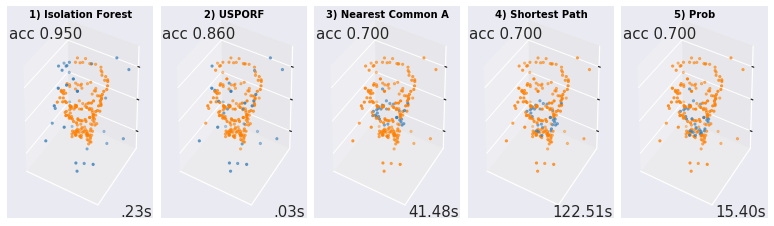

In [51]:
"""
============================================================================
Benchmark performance of different USPORF in 3D toy dataset
============================================================================

This example shows characteristics and compares the performance of USPORF
with different distance matrices on 3D datasets.

Algorithms:
- Isolation Forest, `sklearn.ensemble.IsolationForest`
- Unsupervised Sparse Projection Oblique Randomer Forest(USPORF), 
`UnsupervisedRandomForest`
- RandomTreesEmbedding

RandomTreesEmbedding's distance matrics:
- The depth of the nearest common ancestor of the leaf nodes
- The length of the shortest path of the leaf nodes
- The probability

Benchmarks
- accuracy_score
- roc_auc_score?

"""


#-------------------------------------------------------------------
# Graphing and calculation packages
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
from sklearn.datasets import make_moons, make_blobs

# Algorithm packages
from sklearn import svm
from sklearn.ensemble import IsolationForest
from rerf.urerf import UnsupervisedRandomForest

# Performance measurement packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import tree
from sklearn import datasets
import matplotlib.cm as cm
from sklearn.ensemble import RandomTreesEmbedding


#-------------------------------------------------------------------
# Data parameter
d_noise = 0  # number of Gaussian dimensional noise
n_samples = 200
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
line_sd = 0.06  # sd of the line in dataset 1 and 2
cluster_sd = 0.2  # sd of the cluster in dataset 4 and 5
noise_sd = 2  # sd of the cluster in dimensional noise

# Define datasets
## 1: Linear
def fun_linear(samples=1, sd=0.0):
    t_lin = np.transpose(np.linspace(-1, 1, samples))
    X_lin = np.c_[
        0.4 * t_lin + sd * np.random.randn(samples),
        0.6 * t_lin + sd * np.random.randn(samples),
        t_lin + sd * np.random.randn(samples),
    ]
    return X_lin


X_lin = fun_linear(samples=n_inliers, sd=line_sd)

## 2: Helix
def fun_helix(samples=1, sd=0.0):
    t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, samples))
    xline = t_hex * np.cos(t_hex)  # before rescale
    xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(samples)
    yline = t_hex * np.sin(t_hex)  # before rescale
    yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(samples)
    zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
        max(t_hex) - min(t_hex)
    ) * 2 + sd * np.random.randn(samples)
    X_hex = np.c_[xline, yline, zline]
    return X_hex


X_hex = fun_helix(samples=n_inliers, sd=line_sd)

## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))

## 4: Gaussian Mixture
def gaussian_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_gau = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_gau


X_gau = gaussian_blobs(samples=n_inliers, sd=cluster_sd)

## 5: Misaligned Gaussian Mixture
def misaligned_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_misaligned = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_misaligned


X_misaligned = misaligned_blobs(samples=n_inliers, sd=cluster_sd)

## 6: Whole dataset
# datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]
datasets3D = [ X_hex]

# define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
# label 1 as inliers, -1 as outliers

#-------------------------------------------------------------------
# Define algorithm to be compared
anomaly_algorithms = [
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         behaviour = "new", random_state=42)),
    (
        "USPORF",
        UnsupervisedRandomForest(
            feature_combinations="auto",
            max_depth=None,
            max_features="auto",
            min_samples_split="auto",
            n_estimators=50,
            n_jobs=None,
            projection_matrix="RerF",
        ),
    ),
    (
        "Nearest Common A", 
     RandomTreesEmbedding(n_estimators=50, random_state=42, max_depth=5)
    ),
    (
        "Shortest Path", 
     RandomTreesEmbedding(n_estimators=50, random_state=42, max_depth=5)
    ),
    (
        "Prob", 
     RandomTreesEmbedding(n_estimators=50, random_state=42, max_depth=5)
    )

]



#-------------------------------------------------------------------
# related functions

# the depth of the nearest common ancestor of the leaf nodes 
# sample i and j land into (take the reciprocal to make it a distance);
def NCA(forest, samples):
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)

    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
    
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                d[i, j] = d[i, j]+(path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
            

    d = d / n_estimator
    d_Nearest_Common_Ancestor = [1/x for x in d]
    d_Nearest_Common_Ancestor = np.asarray(d_Nearest_Common_Ancestor)
    
    return d_Nearest_Common_Ancestor

# the length of the shortest path of the leaf nodes sample i and j land into
def SP(forest, samples): 
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)
    
    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
        
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                splitting_depth = (path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
                depth_i = (path[[i, i]].sum(axis=0) == len(sample_ids)).sum()
                depth_j = (path[[j, j]].sum(axis=0) == len(sample_ids)).sum()
                d[i, j] = d[i, j]+depth_i+depth_j-2*splitting_depth

    d_shortest_path = d / n_estimator
    return d_shortest_path


# the probability of sample i and j landing into the same lead node
# (take 1 minus the value to make it a distance).
def PM(clf, samples): 
    
    n_sample = samples.shape[0]
    Y = clf.transform(samples)
    prob = np.zeros([n_sample, n_sample])
    
    for i in range(n_sample):
        for j in range(n_sample):
            leaf_i = Y[i, :]
            leaf_j = Y[j, :]
            p = leaf_i.dot(leaf_j.transpose()).todense()
            prob[i, j] = p[0, 0]

    prob = 1 - prob / Y.shape[1]
    return prob

# predict outliers from the distance matrics
def OutPredict(mat, data):
    sim_sum = mat.sum(axis=1) # score from row sum value
    sU = np.argsort(sim_sum)
    indicesU = sU[
        : int(np.floor(outliers_fraction * data.shape[0]))
    ]  # outlier indeces
    y_pred = np.ones(data.shape[0])
    y_pred[indicesU] = -1
    y_pred = y_pred.astype(int)  # convert float to int array    
    return(y_pred)


#-------------------------------------------------------------------
# Plot
plt.figure(figsize=((len(anomaly_algorithms)) * 2 + 1, len(datasets3D) * 2 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    # add uniform distribution outliers
    X = np.concatenate(
        [X, rng.uniform(low=-1.5, high=1.5, size=(n_outliers, 3))], axis=0
    )
    # add Gaussian dimensional noise, set the center at origin
    X_noise = make_blobs(
        n_samples=n_samples,
        centers=1,
        n_features=d_noise,
        random_state=0,
        cluster_std=1,
        center_box=(0.0, 0.0),
    )[0]
    X = np.append(X, X_noise, axis=1)

    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X) 
        
        # predict outlier ## can be shorten!
        if name == "Isolation Forest":
            y_pred = algorithm.fit(X).predict(X)
       
        elif name == "USPORF":  # USPORF doesn't have predict function
            d_sim = algorithm.transform()
            y_pred = OutPredict(mat=d_sim , data=X)

        elif name == "Nearest Common A":
            forest = algorithm.estimators_
            d_nca  = NCA(forest, X)
            y_pred = OutPredict(mat=d_nca ,  data=X)

        elif name == "Shortest Path":
            forest = algorithm.estimators_
            d_sp   = SP(forest, X)
            y_pred = OutPredict(mat=d_sp,  data=X)
        
        else:
            d_prob = PM(algorithm, X)
            y_pred = OutPredict(mat=d_prob,  data=X)   
        t1 = time.time()
        
        # compute the accuracy
        acc = accuracy_score(y_true, y_pred)

        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms), plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ") " + name, size=10, color="black", weight="bold"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1
print("d_noise = ", str(d_noise))
plt.show()

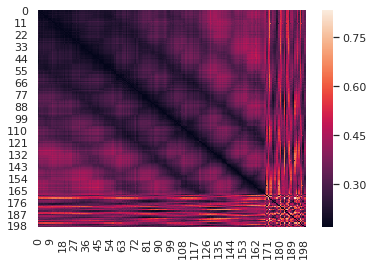

In [53]:
import seaborn as sns; sns.set()
ax = sns.heatmap(d_nca)

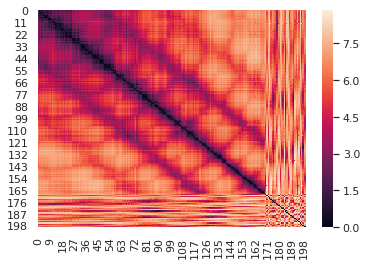

In [55]:
ax = sns.heatmap(d_sp)

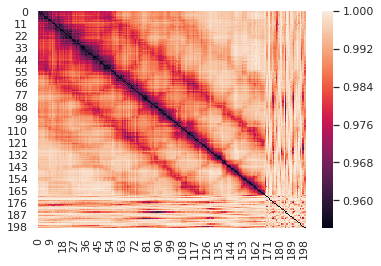

In [56]:
ax = sns.heatmap(d_prob)

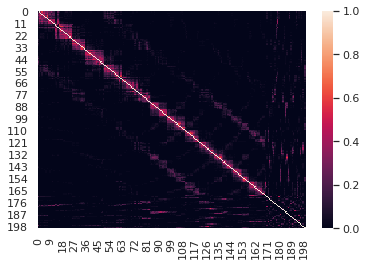

In [57]:
ax = sns.heatmap(d_sim)